# Eps-Greedy Global vs Local Diagnostics

This notebook builds stronger diagnostics for eps-greedy efficiency as a function of denoising time.

For each `model x reward` panel (2x3), we compute from `candidate_eval` logs:
- `avg_global`: average reward of **all global** candidates (Tweedie-based)
- `best_global`: best reward among global candidates
- `best_local`: best reward among local candidates

Then we compute, from **all candidate points**:
- bias point: `score(candidate) - final_reward`
- `sd_bias_t`: standard deviation of bias at each timestep

Finally we plot:
1. reward curves (`avg_global`, `best_global`, `best_local`)
2. `sd_bias_t`
3. overlay of (1) with `sd_bias_t`
4. normalized gap: `(best_local - avg_global) / sd_bias_t`

Aggregations shown:
- 2x3 panels (`model x reward`)
- pooled across rewards (within each model)
- pooled across all models/rewards (using normalized denoising progress in [0,1])

Notes:
- SD and EDM use different timestep-value scales; model-specific axis scales are configurable.
- Malformed JSON lines are skipped safely.


In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext

plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
# -------- Config --------
EXPERIMENT_NAME = 'inefficiency'
ROOT_LOG_BASE = Path('../logs/search_stats')

MODELS = ['EDM', 'SD']
COL_KEYS = ['brightness', 'compressibility', 'classifier_or_clip']
COL_LABELS = {
    'brightness': 'Brightness',
    'compressibility': 'Compressibility',
    'classifier_or_clip': 'Classifier / CLIP',
}
REWARD_DIR_BY_MODEL = {
    'EDM': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLASSIFIER',
    },
    'SD': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLIP',
    },
}

# Use run_end.best_score as final reward when available and source has a single sample.
USE_RUN_END_FINAL = True

# Axis behavior by model for timestep_value plots
X_SCALE_BY_MODEL = {'EDM': 'log', 'SD': 'linear'}
X_LIM_BY_MODEL = {'EDM': None, 'SD': None}

# Global pooled curves use normalized progress bins
PROGRESS_BIN_DECIMALS = 2

ROOT_LOG_BASE / EXPERIMENT_NAME


PosixPath('../logs/search_stats/inefficiency')

In [3]:
def _parse_log(log_path: Path):
    rows = []
    run_end_best = None

    with log_path.open('r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            try:
                e = json.loads(line)
            except json.JSONDecodeError:
                continue

            et = e.get('event_type')
            if et == 'candidate_eval':
                rows.append({
                    'source': str(log_path),
                    'sample_idx': int(e.get('sample_idx', 0)),
                    'timestep_idx': int(e['timestep_idx']),
                    'timestep_value': float(e.get('timestep_value', np.nan)),
                    'local_iter_idx': int(e['local_iter_idx']),
                    'candidate_idx': int(e.get('candidate_idx', -1)),
                    'is_global_candidate': bool(e['is_global_candidate']),
                    'is_winner': bool(e.get('is_winner', False)),
                    'winner_score': float(e.get('winner_score', e['score'])) if e.get('winner_score', e.get('score')) is not None else np.nan,
                    'score': float(e['score']),
                })
            elif et == 'run_end' and e.get('best_score') is not None:
                run_end_best = float(e['best_score'])

    return rows, run_end_best


def _attach_final_reward(df: pd.DataFrame, run_end_best_by_source: dict, use_run_end_final: bool = True):
    if df.empty:
        out = df.copy()
        out['final_reward'] = np.nan
        return out

    keys_unit = ['source', 'sample_idx']

    winners = df[df['is_winner']].copy()
    if winners.empty:
        # Fallback: use last timestep/local-iter max score if winner flags are missing
        tmp = (
            df.sort_values(['source', 'sample_idx', 'timestep_idx', 'local_iter_idx'])
              .groupby(keys_unit, as_index=False)
              .tail(1)
        )
        tmp = tmp.rename(columns={'score': 'winner_score'})
        winners = tmp

    winners_last = (
        winners.sort_values(['source', 'sample_idx', 'timestep_idx', 'local_iter_idx'])
               .groupby(keys_unit, as_index=False)
               .tail(1)
               .copy()
    )
    winners_last['final_reward_fallback'] = winners_last['winner_score'].astype(float)

    final_map = winners_last[keys_unit + ['final_reward_fallback']].copy()

    if use_run_end_final and len(run_end_best_by_source) > 0:
        n_samples_per_source = df.groupby('source')['sample_idx'].nunique().to_dict()
        run_end_rows = []
        for src, best in run_end_best_by_source.items():
            if n_samples_per_source.get(src, 0) == 1:
                sample_idx = int(df.loc[df['source'] == src, 'sample_idx'].iloc[0])
                run_end_rows.append({'source': src, 'sample_idx': sample_idx, 'final_reward_run_end': float(best)})

        if run_end_rows:
            run_end_df = pd.DataFrame(run_end_rows)
            final_map = final_map.merge(run_end_df, on=keys_unit, how='left')
            final_map['final_reward'] = final_map['final_reward_run_end'].combine_first(final_map['final_reward_fallback'])
        else:
            final_map['final_reward'] = final_map['final_reward_fallback']
    else:
        final_map['final_reward'] = final_map['final_reward_fallback']

    out = df.merge(final_map[keys_unit + ['final_reward']], on=keys_unit, how='left')
    return out


def _add_progress(df: pd.DataFrame, bin_decimals: int = 2):
    if df.empty:
        out = df.copy()
        out['progress'] = np.nan
        out['progress_bin'] = np.nan
        return out

    out = df.copy()
    grp = ['source', 'sample_idx']
    tmax = out.groupby(grp)['timestep_idx'].transform('max').astype(float)
    tmax = tmax.replace(0.0, np.nan)
    out['progress'] = (out['timestep_idx'].astype(float) / tmax).fillna(0.0)
    out['progress_bin'] = out['progress'].round(bin_decimals)
    return out


def _metrics_unit_t(df: pd.DataFrame):
    keys = ['source', 'sample_idx', 'timestep_idx']
    out = (
        df.groupby(keys, as_index=False)
          .agg(
              timestep_value=('timestep_value', 'first'),
              avg_global=(
                  'score',
                  lambda s: (
                      float(s[df.loc[s.index, 'is_global_candidate']].mean())
                      if df.loc[s.index, 'is_global_candidate'].any()
                      else np.nan
                  ),
              ),
              best_global=(
                  'score',
                  lambda s: (
                      float(s[df.loc[s.index, 'is_global_candidate']].max())
                      if df.loc[s.index, 'is_global_candidate'].any()
                      else np.nan
                  ),
              ),
              best_local=(
                  'score',
                  lambda s: (
                      float(s[~df.loc[s.index, 'is_global_candidate']].max())
                      if (~df.loc[s.index, 'is_global_candidate']).any()
                      else np.nan
                  ),
              ),
          )
    )
    return out


def _curve_metrics(unit_t: pd.DataFrame, key_col: str, x_col: str):
    if unit_t.empty:
        return pd.DataFrame()

    c = (
        unit_t.groupby(key_col, as_index=False)
              .agg(
                  x=(x_col, 'mean'),
                  avg_global_mean=('avg_global', 'mean'),
                  avg_global_se=('avg_global', 'sem'),
                  best_global_mean=('best_global', 'mean'),
                  best_global_se=('best_global', 'sem'),
                  best_local_mean=('best_local', 'mean'),
                  best_local_se=('best_local', 'sem'),
                  n_units=('avg_global', 'count'),
              )
              .sort_values('x')
    )
    for col in ['avg_global_se', 'best_global_se', 'best_local_se']:
        c[col] = c[col].fillna(0.0)
    return c


def _curve_bias_sd(all_points: pd.DataFrame, key_col: str, x_col: str):
    if all_points.empty:
        return pd.DataFrame()

    c = (
        all_points.groupby(key_col, as_index=False)
                  .agg(
                      x=(x_col, 'mean'),
                      sd_bias=('bias', 'std'),
                      bias_mean=('bias', 'mean'),
                      n_points=('bias', 'count'),
                  )
                  .sort_values('x')
    )
    return c


def _curve_z(metrics_curve: pd.DataFrame, bias_curve: pd.DataFrame, key_col: str):
    if metrics_curve.empty or bias_curve.empty:
        return pd.DataFrame()

    m = metrics_curve.rename(columns={'x': 'x_m'})
    b = bias_curve.rename(columns={'x': 'x_b'})
    c = m.merge(b[[key_col, 'x_b', 'sd_bias']], on=key_col, how='inner')
    c['x'] = c['x_m'].combine_first(c['x_b'])
    denom = c['sd_bias'].replace(0.0, np.nan)
    c['z_local_minus_avg_global'] = (c['best_local_mean'] - c['avg_global_mean']) / denom
    return c.sort_values('x')


def compute_panel_data(log_dir: Path, use_run_end_final: bool = True, progress_bin_decimals: int = 2):
    files = sorted(log_dir.rglob('*.jsonl'))
    if not files:
        return {
            'files': 0, 'rows': 0, 'units': 0, 'points': 0,
            'unit_t': pd.DataFrame(), 'all_points': pd.DataFrame(),
            'metrics_curve': pd.DataFrame(), 'bias_curve': pd.DataFrame(), 'z_curve': pd.DataFrame(),
        }

    all_rows = []
    run_end_best_by_source = {}

    for fp in files:
        rows, run_end_best = _parse_log(fp)
        all_rows.extend(rows)
        if run_end_best is not None:
            run_end_best_by_source[str(fp)] = run_end_best

    if len(all_rows) == 0:
        return {
            'files': len(files), 'rows': 0, 'units': 0, 'points': 0,
            'unit_t': pd.DataFrame(), 'all_points': pd.DataFrame(),
            'metrics_curve': pd.DataFrame(), 'bias_curve': pd.DataFrame(), 'z_curve': pd.DataFrame(),
        }

    df = pd.DataFrame(all_rows)
    df = _attach_final_reward(df, run_end_best_by_source, use_run_end_final=use_run_end_final)

    # all points bias
    all_points = df.copy()
    all_points['bias'] = all_points['score'] - all_points['final_reward']

    # per-(source,sample,timestep) metrics from all candidate points
    unit_t = _metrics_unit_t(df)

    # add normalized progress for global pooled alignment
    unit_t = _add_progress(unit_t, bin_decimals=progress_bin_decimals)
    all_points = _add_progress(all_points, bin_decimals=progress_bin_decimals)

    metrics_curve = _curve_metrics(unit_t, key_col='timestep_idx', x_col='timestep_value')
    bias_curve = _curve_bias_sd(all_points, key_col='timestep_idx', x_col='timestep_value')
    z_curve = _curve_z(metrics_curve, bias_curve, key_col='timestep_idx')

    return {
        'files': len(files),
        'rows': len(df),
        'units': int(unit_t[['source', 'sample_idx']].drop_duplicates().shape[0]) if not unit_t.empty else 0,
        'points': len(all_points),
        'unit_t': unit_t,
        'all_points': all_points,
        'metrics_curve': metrics_curve,
        'bias_curve': bias_curve,
        'z_curve': z_curve,
    }



In [4]:
panel = {}
summary_rows = []

for model in MODELS:
    for col_key in COL_KEYS:
        reward_dir = REWARD_DIR_BY_MODEL[model][col_key]
        log_dir = ROOT_LOG_BASE / EXPERIMENT_NAME / model / reward_dir

        data = compute_panel_data(
            log_dir,
            use_run_end_final=USE_RUN_END_FINAL,
            progress_bin_decimals=PROGRESS_BIN_DECIMALS,
        )

        panel[(model, col_key)] = data
        summary_rows.append({
            'model': model,
            'column': col_key,
            'reward_label': COL_LABELS[col_key],
            'files': data['files'],
            'rows': data['rows'],
            'units': data['units'],
            'points': data['points'],
        })

summary_df = pd.DataFrame(summary_rows)
summary_df


,model,column,reward_label,files,rows,units,points
0,EDM,brightness,Brightness,1,14400,10,14400
1,EDM,compressibility,Compressibility,1,14400,10,14400
2,EDM,classifier_or_clip,Classifier / CLIP,1,14400,10,14400
3,SD,brightness,Brightness,10,40000,10,40000
4,SD,compressibility,Compressibility,10,40000,10,40000
5,SD,classifier_or_clip,Classifier / CLIP,10,40000,10,40000


In [5]:
summary_df.sort_values(['model', 'column'])


,model,column,reward_label,files,rows,units,points
0,EDM,brightness,Brightness,1,14400,10,14400
2,EDM,classifier_or_clip,Classifier / CLIP,1,14400,10,14400
1,EDM,compressibility,Compressibility,1,14400,10,14400
3,SD,brightness,Brightness,10,40000,10,40000
5,SD,classifier_or_clip,Classifier / CLIP,10,40000,10,40000
4,SD,compressibility,Compressibility,10,40000,10,40000


In [6]:
def infer_model_xlim(model: str):
    manual = X_LIM_BY_MODEL.get(model)
    if manual is not None:
        return manual

    vals = []
    for col_key in COL_KEYS:
        c = panel[(model, col_key)]['metrics_curve']
        if c is None or c.empty:
            continue
        vals.extend(c['x'].dropna().tolist())

    if not vals:
        return None

    arr = np.asarray(vals, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return None

    scale = X_SCALE_BY_MODEL.get(model, 'log')
    if scale == 'log':
        arr = arr[arr > 0]
        if arr.size == 0:
            return None
        lo = 10 ** np.floor(np.log10(arr.min()))
        hi = 10 ** np.ceil(np.log10(arr.max()))
        if lo == hi:
            lo /= 10.0
            hi *= 10.0
        return (float(lo), float(hi))

    lo = float(arr.min())
    hi = float(arr.max())
    if lo == hi:
        lo -= 1.0
        hi += 1.0
    pad = 0.03 * (hi - lo)
    return (lo - pad, hi + pad)


xlim_by_model = {m: infer_model_xlim(m) for m in MODELS}
xlim_by_model


{'EDM': (0.001, 100.0), 'SD': (-28.4, 1010.4)}

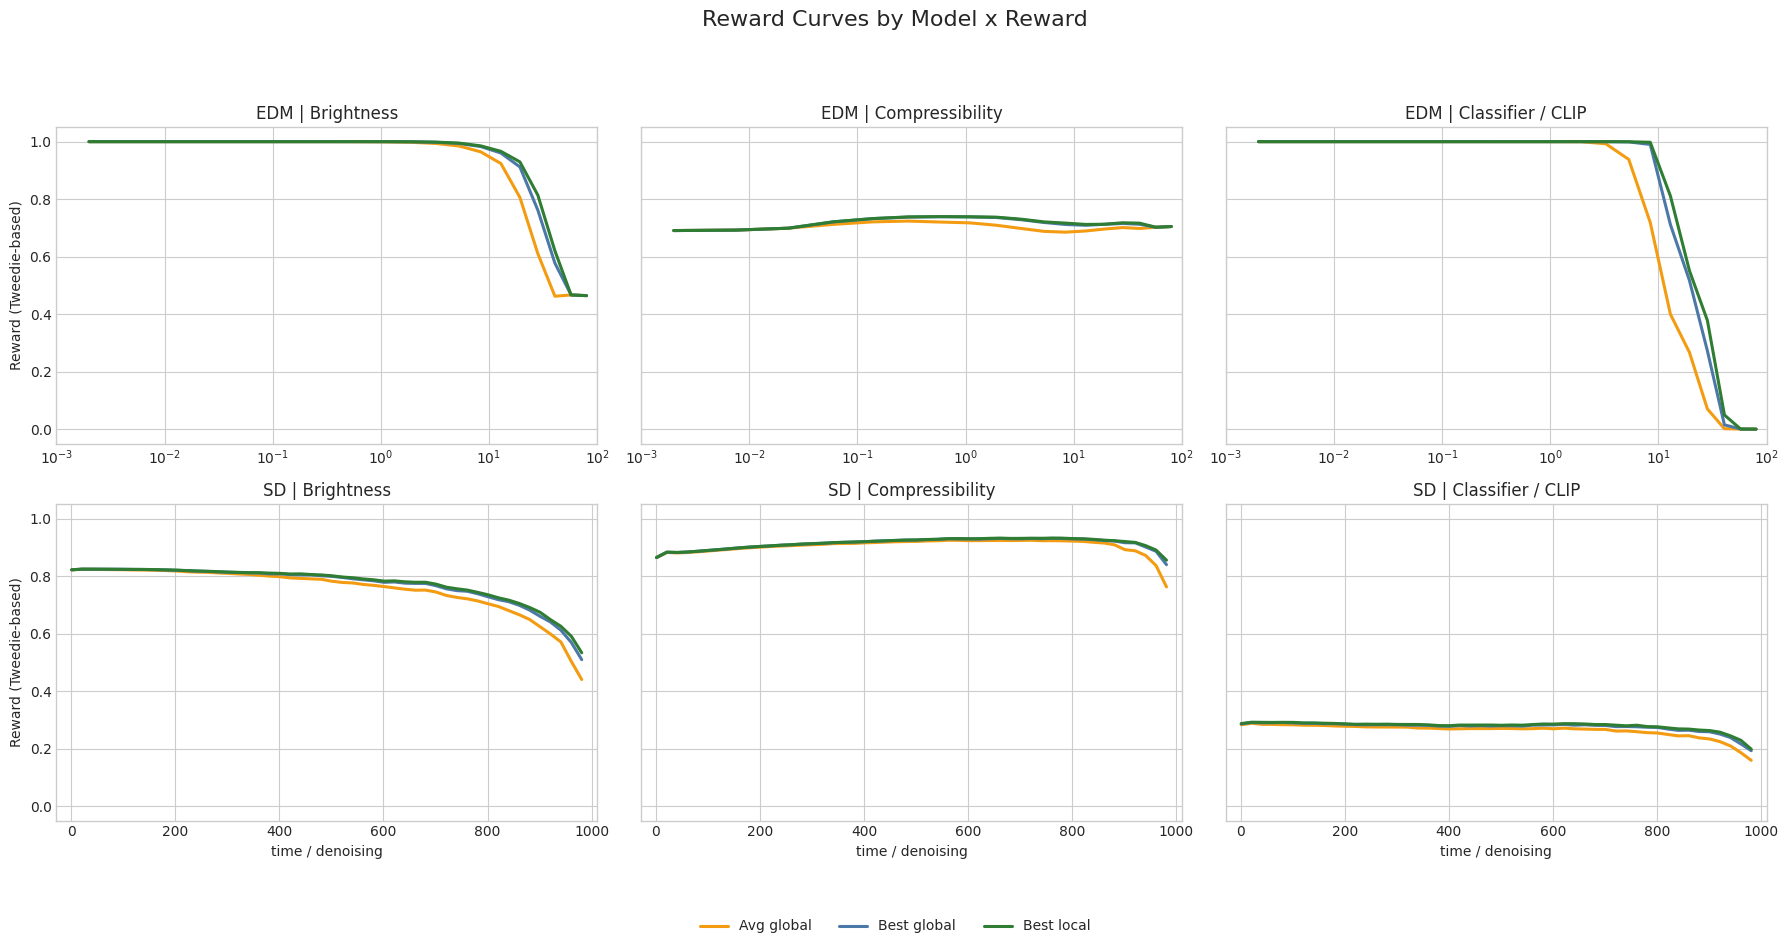

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=True)
for r, model in enumerate(MODELS):
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)
    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        curve = panel[(model, col_key)]['metrics_curve']

        if curve is None or curve.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        ax.plot(curve['x'], curve['avg_global_mean'], color='#F39C12', linewidth=2.2, label='Avg global')
        ax.plot(curve['x'], curve['best_global_mean'], color='#4C78A8', linewidth=2.2, label='Best global')
        ax.plot(curve['x'], curve['best_local_mean'], color='#2E7D32', linewidth=2.2, label='Best local')

        ax.set_title(f'{model} | {COL_LABELS[col_key]}')
        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
        if model_xlim is not None:
            ax.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('time / denoising')
for ax in axes[:, 0]:
    ax.set_ylabel('Reward (Tweedie-based)')

handles, labels = axes[0,0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, frameon=False)
fig.suptitle('Reward Curves by Model x Reward', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.show()

In [8]:
pooled_model = {}
for model in MODELS:
    unit_parts = [panel[(model, c)]['unit_t'] for c in COL_KEYS if not panel[(model, c)]['unit_t'].empty]
    point_parts = [panel[(model, c)]['all_points'] for c in COL_KEYS if not panel[(model, c)]['all_points'].empty]

    if unit_parts:
        unit_df = pd.concat(unit_parts, ignore_index=True)
        m_curve = _curve_metrics(unit_df, key_col='timestep_idx', x_col='timestep_value')
    else:
        unit_df = pd.DataFrame()
        m_curve = pd.DataFrame()

    if point_parts:
        points_df = pd.concat(point_parts, ignore_index=True)
        b_curve = _curve_bias_sd(points_df, key_col='timestep_idx', x_col='timestep_value')
    else:
        points_df = pd.DataFrame()
        b_curve = pd.DataFrame()

    z_curve = _curve_z(m_curve, b_curve, key_col='timestep_idx') if (not m_curve.empty and not b_curve.empty) else pd.DataFrame()

    pooled_model[model] = {
        'unit_t': unit_df,
        'all_points': points_df,
        'metrics_curve': m_curve,
        'bias_curve': b_curve,
        'z_curve': z_curve,
    }

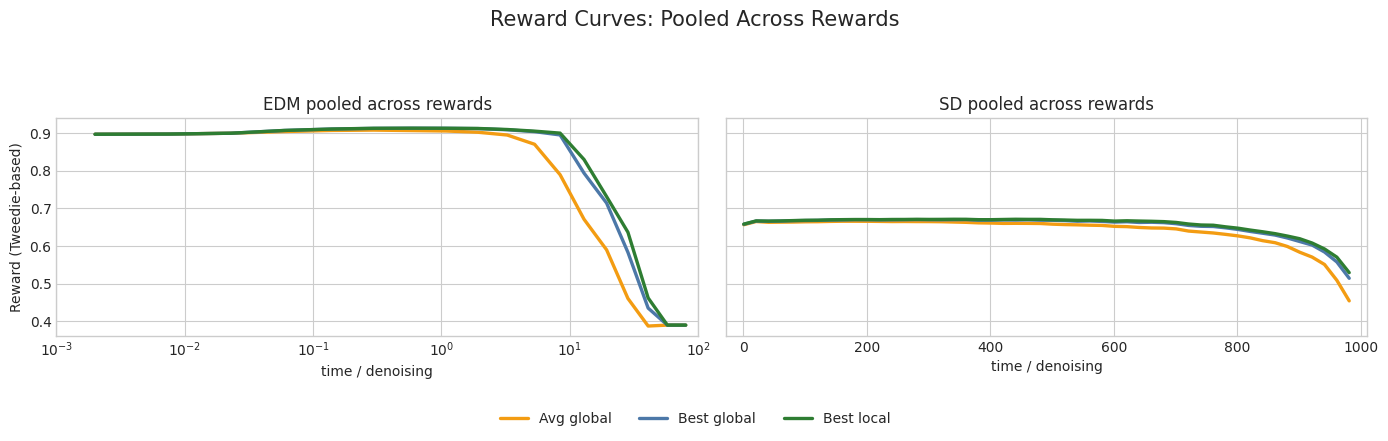

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
if len(MODELS) == 1:
    axes = [axes]

for i, model in enumerate(MODELS):
    ax = axes[i]
    curve = pooled_model[model]['metrics_curve']
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)

    if curve.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} pooled')
        continue

    ax.plot(curve['x'], curve['avg_global_mean'], color='#F39C12', linewidth=2.4, label='Avg global')
    ax.plot(curve['x'], curve['best_global_mean'], color='#4C78A8', linewidth=2.4, label='Best global')
    ax.plot(curve['x'], curve['best_local_mean'], color='#2E7D32', linewidth=2.4, label='Best local')
    ax.set_title(f'{model} pooled across rewards')
    ax.set_xlabel('time / denoising')

    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)

axes[0].set_ylabel('Reward (Tweedie-based)')
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=3, frameon=False)
fig.suptitle('Reward Curves: Pooled Across Rewards', y=1.04, fontsize=15)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

In [10]:
# Pooled-across-all (all models + all rewards) plot intentionally removed.

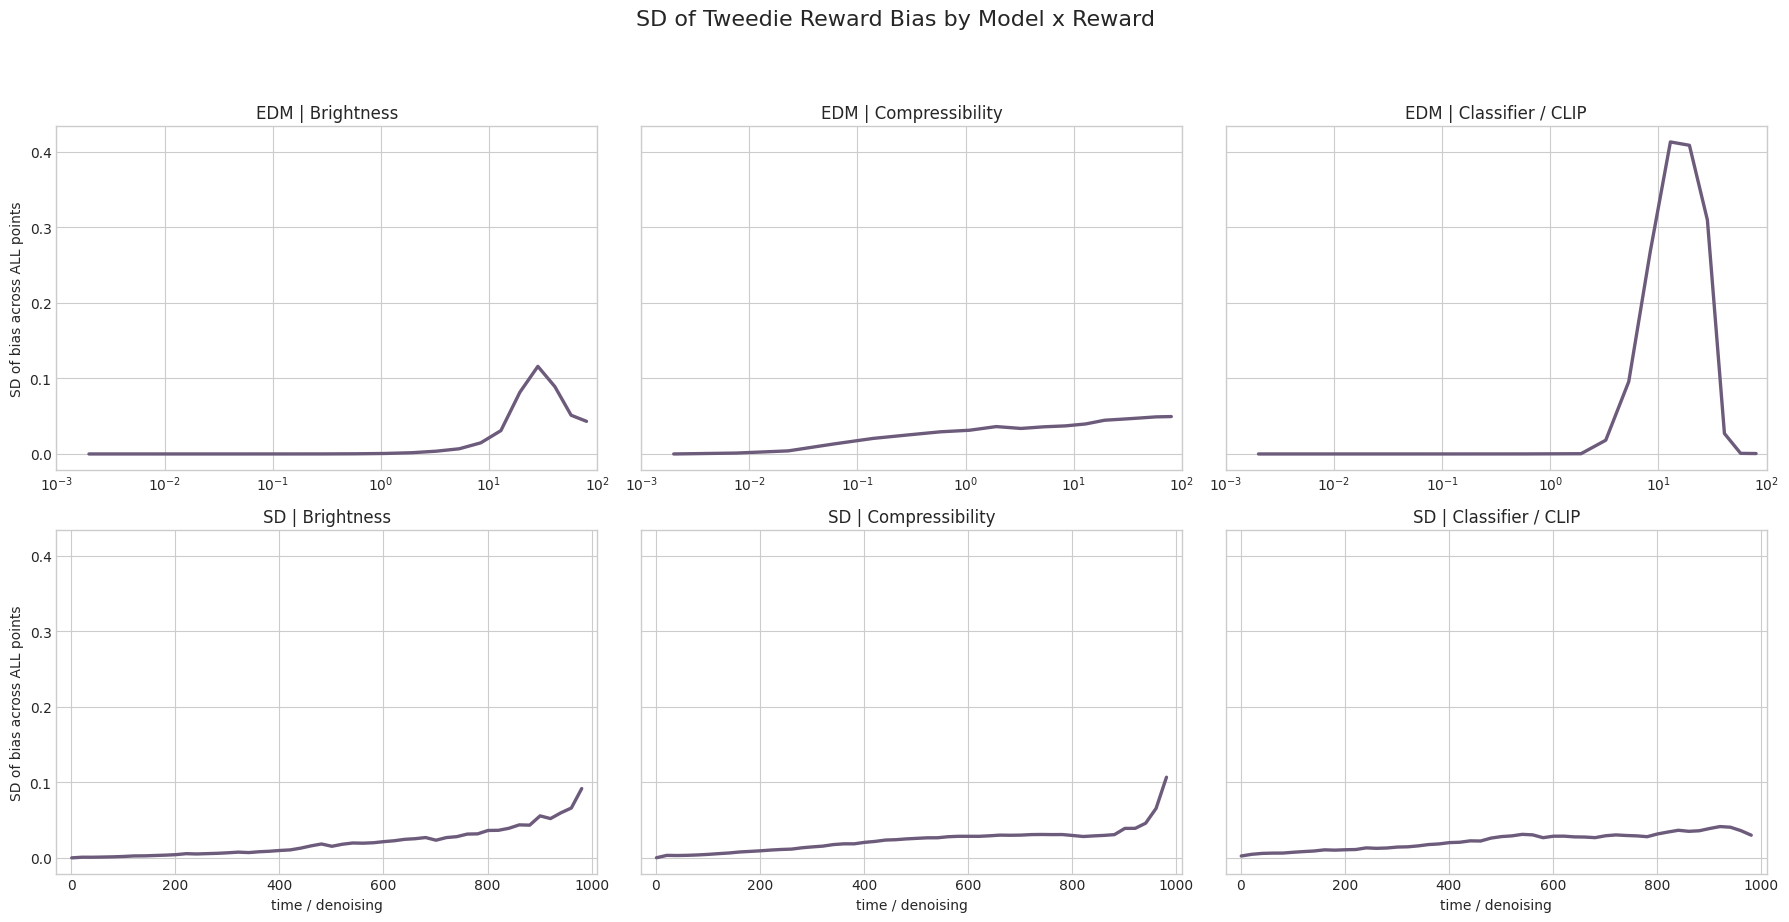

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=True)
for r, model in enumerate(MODELS):
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)
    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        curve = panel[(model, col_key)]['bias_curve']

        if curve is None or curve.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        ax.plot(curve['x'], curve['sd_bias'], color='#6C5B7B', linewidth=2.4)
        ax.set_title(f'{model} | {COL_LABELS[col_key]}')

        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
        if model_xlim is not None:
            ax.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('time / denoising')
for ax in axes[:, 0]:
    ax.set_ylabel('SD of bias across ALL points')

fig.suptitle('SD of Tweedie Reward Bias by Model x Reward', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

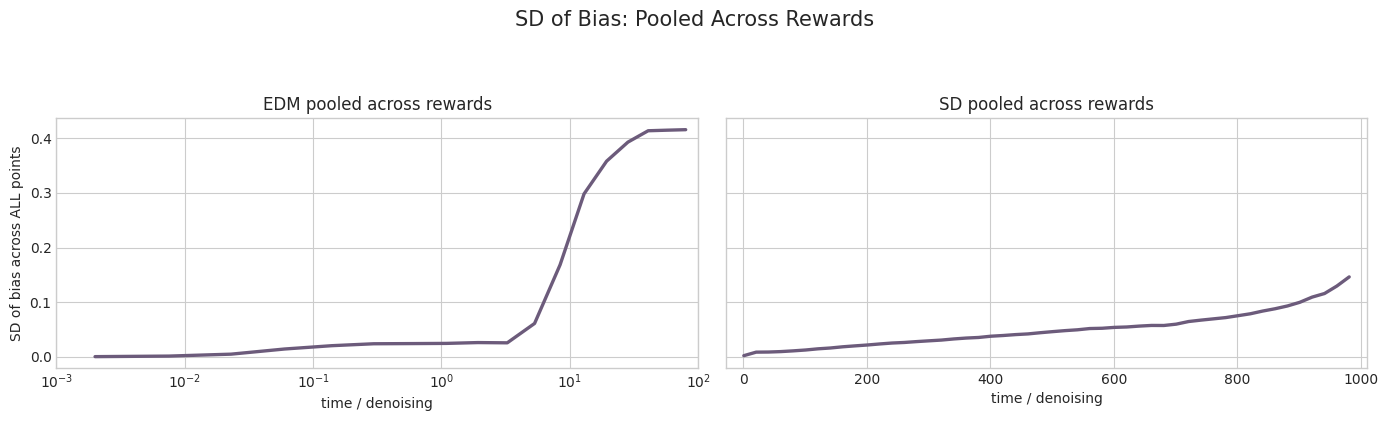

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
if len(MODELS) == 1:
    axes = [axes]

for i, model in enumerate(MODELS):
    ax = axes[i]
    curve = pooled_model[model]['bias_curve']
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)

    if curve.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} pooled')
        continue

    ax.plot(curve['x'], curve['sd_bias'], color='#6C5B7B', linewidth=2.4)
    ax.set_title(f'{model} pooled across rewards')
    ax.set_xlabel('time / denoising')

    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)

axes[0].set_ylabel('SD of bias across ALL points')
fig.suptitle('SD of Bias: Pooled Across Rewards', y=1.04, fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

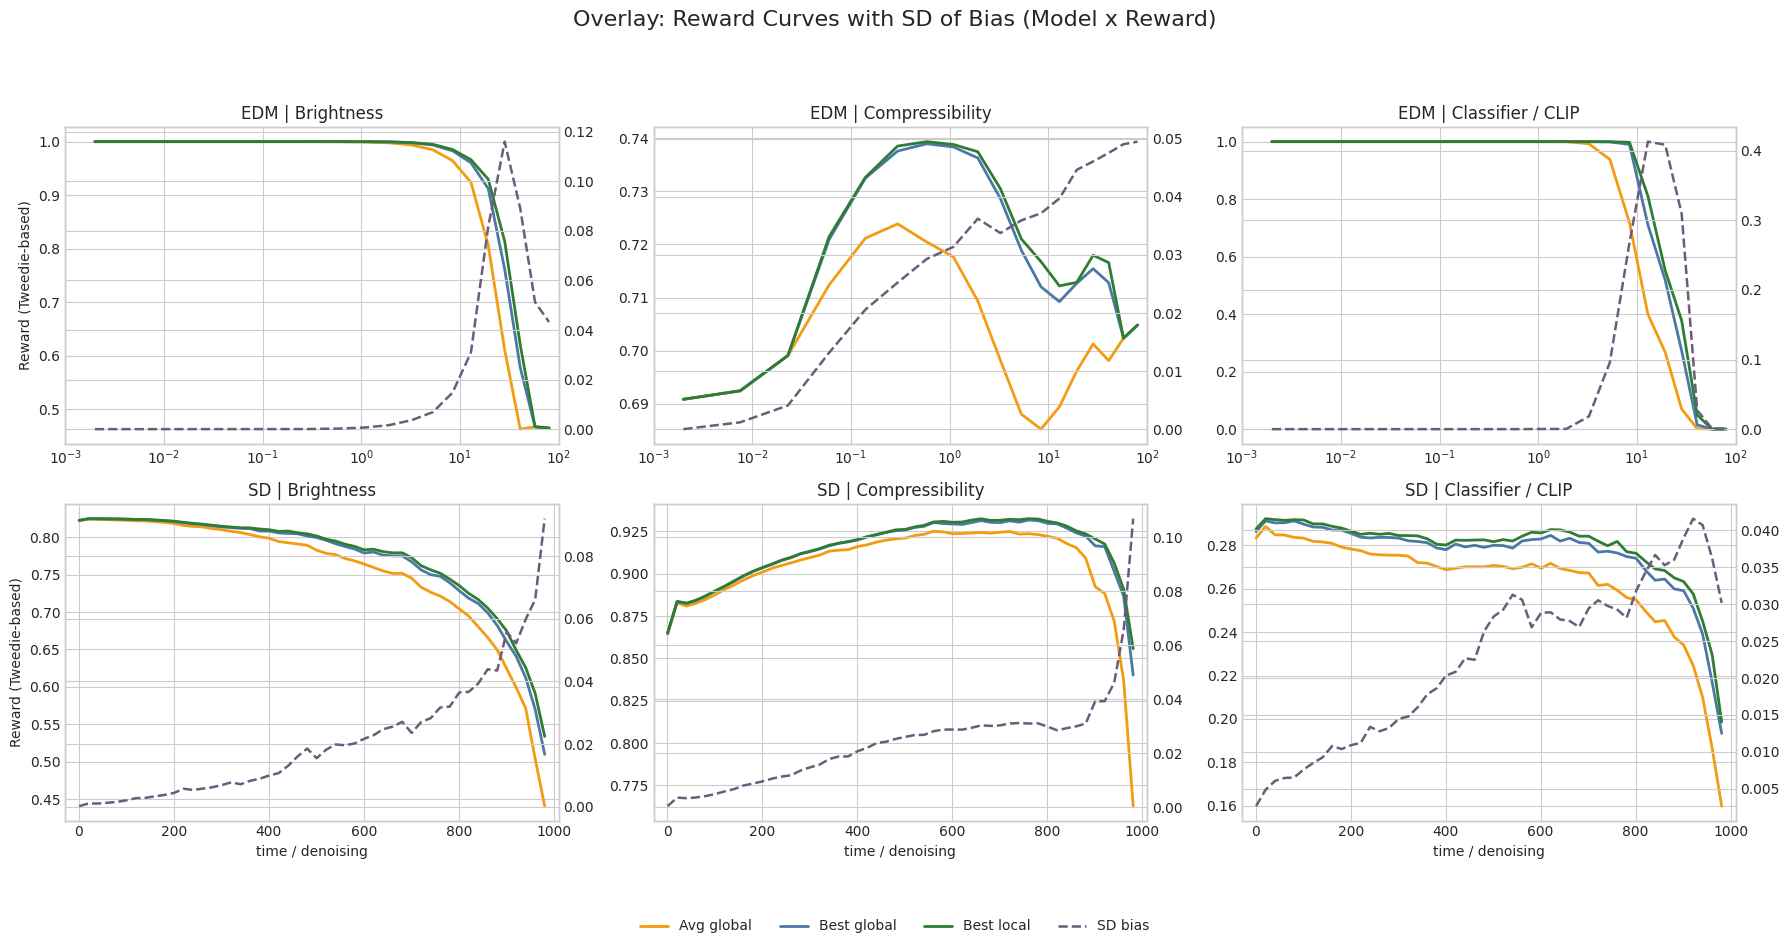

In [13]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=False)
for r, model in enumerate(MODELS):
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)
    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        mcurve = panel[(model, col_key)]['metrics_curve']
        bcurve = panel[(model, col_key)]['bias_curve']

        if mcurve.empty or bcurve.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        ax.plot(mcurve['x'], mcurve['avg_global_mean'], color='#F39C12', linewidth=2.0)
        ax.plot(mcurve['x'], mcurve['best_global_mean'], color='#4C78A8', linewidth=2.0)
        ax.plot(mcurve['x'], mcurve['best_local_mean'], color='#2E7D32', linewidth=2.0)

        ax2 = ax.twinx()
        ax2.plot(bcurve['x'], bcurve['sd_bias'], color='#6C5B7B', linewidth=1.8, linestyle='--')

        ax.set_title(f'{model} | {COL_LABELS[col_key]}')
        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
            ax2.set_xscale('log')
        if model_xlim is not None:
            ax.set_xlim(*model_xlim)
            ax2.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('time / denoising')
for ax in axes[:, 0]:
    ax.set_ylabel('Reward (Tweedie-based)')

legend_handles = [
    Line2D([0], [0], color='#F39C12', linewidth=2.0, label='Avg global'),
    Line2D([0], [0], color='#4C78A8', linewidth=2.0, label='Best global'),
    Line2D([0], [0], color='#2E7D32', linewidth=2.0, label='Best local'),
    Line2D([0], [0], color='#6C5B7B', linewidth=1.8, linestyle='--', label='SD bias'),
]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, frameon=False)
fig.suptitle('Overlay: Reward Curves with SD of Bias (Model x Reward)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.show()

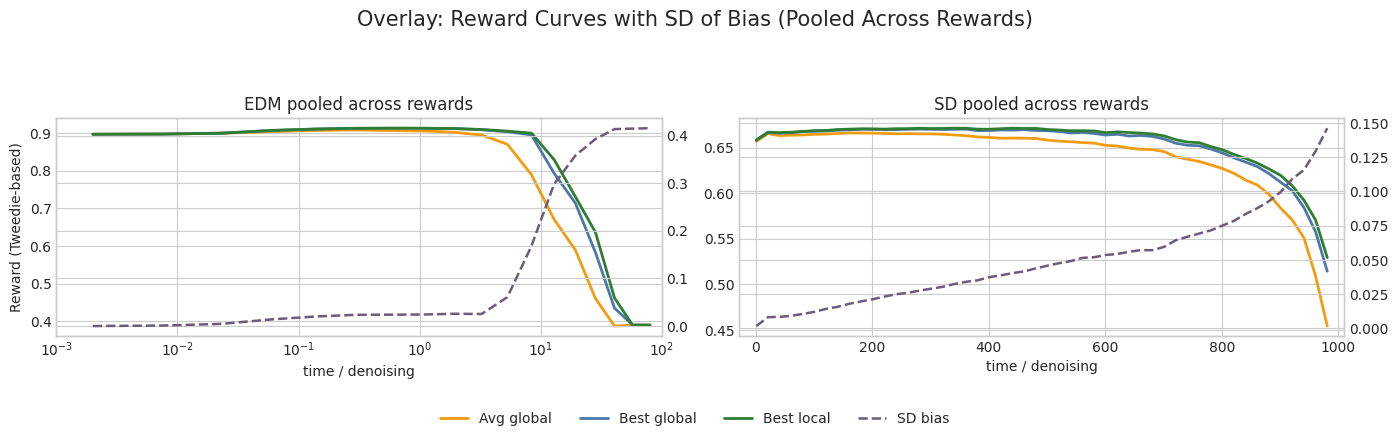

In [14]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)
if len(MODELS) == 1:
    axes = [axes]

for i, model in enumerate(MODELS):
    ax = axes[i]
    mcurve = pooled_model[model]['metrics_curve']
    bcurve = pooled_model[model]['bias_curve']
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)

    if mcurve.empty or bcurve.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} pooled')
        continue

    ax.plot(mcurve['x'], mcurve['avg_global_mean'], color='#F39C12', linewidth=2.0)
    ax.plot(mcurve['x'], mcurve['best_global_mean'], color='#4C78A8', linewidth=2.0)
    ax.plot(mcurve['x'], mcurve['best_local_mean'], color='#2E7D32', linewidth=2.0)

    ax2 = ax.twinx()
    ax2.plot(bcurve['x'], bcurve['sd_bias'], color='#6C5B7B', linewidth=1.8, linestyle='--')

    ax.set_title(f'{model} pooled across rewards')
    ax.set_xlabel('time / denoising')
    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
        ax2.set_xscale('log')
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)
        ax2.set_xlim(*model_xlim)

axes[0].set_ylabel('Reward (Tweedie-based)')
legend_handles = [
    Line2D([0], [0], color='#F39C12', linewidth=2.0, label='Avg global'),
    Line2D([0], [0], color='#4C78A8', linewidth=2.0, label='Best global'),
    Line2D([0], [0], color='#2E7D32', linewidth=2.0, label='Best local'),
    Line2D([0], [0], color='#6C5B7B', linewidth=1.8, linestyle='--', label='SD bias'),
]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=4, frameon=False)
fig.suptitle('Overlay: Reward Curves with SD of Bias (Pooled Across Rewards)', y=1.04, fontsize=15)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

In [ ]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=False)
for r, model in enumerate(MODELS):
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)
    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        mcurve = panel[(model, col_key)]['metrics_curve']
        bcurve = panel[(model, col_key)]['bias_curve']

        if mcurve.empty or bcurve.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        diff_local = mcurve['best_local_mean'] - mcurve['avg_global_mean']
        diff_global = mcurve['best_global_mean'] - mcurve['avg_global_mean']

        ax.plot(mcurve['x'], diff_local, color='#C0392B', linewidth=2.1)
        ax.plot(mcurve['x'], diff_global, color='#1F77B4', linewidth=2.1)
        ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.0)

        ax2 = ax.twinx()
        ax2.plot(bcurve['x'], bcurve['sd_bias'], color='#6C5B7B', linewidth=1.8, linestyle='--')

        ax.set_title(f'{model} | {COL_LABELS[col_key]}')
        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
            ax2.set_xscale('log')
        if model_xlim is not None:
            ax.set_xlim(*model_xlim)
            ax2.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('time / denoising')
for ax in axes[:, 0]:
    ax.set_ylabel('Reward gap vs avg_global')

legend_handles = [
    Line2D([0], [0], color='#C0392B', linewidth=2.1, label='best_local - avg_global'),
    Line2D([0], [0], color='#1F77B4', linewidth=2.1, label='best_global - avg_global'),
    Line2D([0], [0], color='#6C5B7B', linewidth=1.8, linestyle='--', label='SD bias'),
]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, frameon=False)
fig.suptitle('Unnormalized Gaps with SD of Bias (Model x Reward)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.show()

In [ ]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)
if len(MODELS) == 1:
    axes = [axes]

for i, model in enumerate(MODELS):
    ax = axes[i]
    mcurve = pooled_model[model]['metrics_curve']
    bcurve = pooled_model[model]['bias_curve']
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)

    if mcurve.empty or bcurve.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} pooled')
        continue

    diff_local = mcurve['best_local_mean'] - mcurve['avg_global_mean']
    diff_global = mcurve['best_global_mean'] - mcurve['avg_global_mean']

    ax.plot(mcurve['x'], diff_local, color='#C0392B', linewidth=2.1)
    ax.plot(mcurve['x'], diff_global, color='#1F77B4', linewidth=2.1)
    ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.0)

    ax2 = ax.twinx()
    ax2.plot(bcurve['x'], bcurve['sd_bias'], color='#6C5B7B', linewidth=1.8, linestyle='--')

    ax.set_title(f'{model} pooled across rewards')
    ax.set_xlabel('time / denoising')
    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
        ax2.set_xscale('log')
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)
        ax2.set_xlim(*model_xlim)

axes[0].set_ylabel('Reward gap vs avg_global')
legend_handles = [
    Line2D([0], [0], color='#C0392B', linewidth=2.1, label='best_local - avg_global'),
    Line2D([0], [0], color='#1F77B4', linewidth=2.1, label='best_global - avg_global'),
    Line2D([0], [0], color='#6C5B7B', linewidth=1.8, linestyle='--', label='SD bias'),
]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=3, frameon=False)
fig.suptitle('Unnormalized Gaps with SD of Bias (Pooled Across Rewards)', y=1.04, fontsize=15)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

In [ ]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=False)
for r, model in enumerate(MODELS):
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)
    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        mcurve = panel[(model, col_key)]['metrics_curve']
        bcurve = panel[(model, col_key)]['bias_curve']

        if mcurve.empty or bcurve.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        diff_local_minus_global = mcurve['best_local_mean'] - mcurve['best_global_mean']

        ax.plot(mcurve['x'], diff_local_minus_global, color='#8E44AD', linewidth=2.2)
        ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.0)

        ax2 = ax.twinx()
        ax2.plot(bcurve['x'], bcurve['sd_bias'], color='#6C5B7B', linewidth=1.8, linestyle='--')

        ax.set_title(f'{model} | {COL_LABELS[col_key]}')
        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
            ax2.set_xscale('log')
        if model_xlim is not None:
            ax.set_xlim(*model_xlim)
            ax2.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('time / denoising')
for ax in axes[:, 0]:
    ax.set_ylabel('best_local - best_global')

legend_handles = [
    Line2D([0], [0], color='#8E44AD', linewidth=2.2, label='best_local - best_global'),
    Line2D([0], [0], color='#6C5B7B', linewidth=1.8, linestyle='--', label='SD bias'),
]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, frameon=False)
fig.suptitle('Best-Local Minus Best-Global with SD of Bias (Model x Reward)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.show()

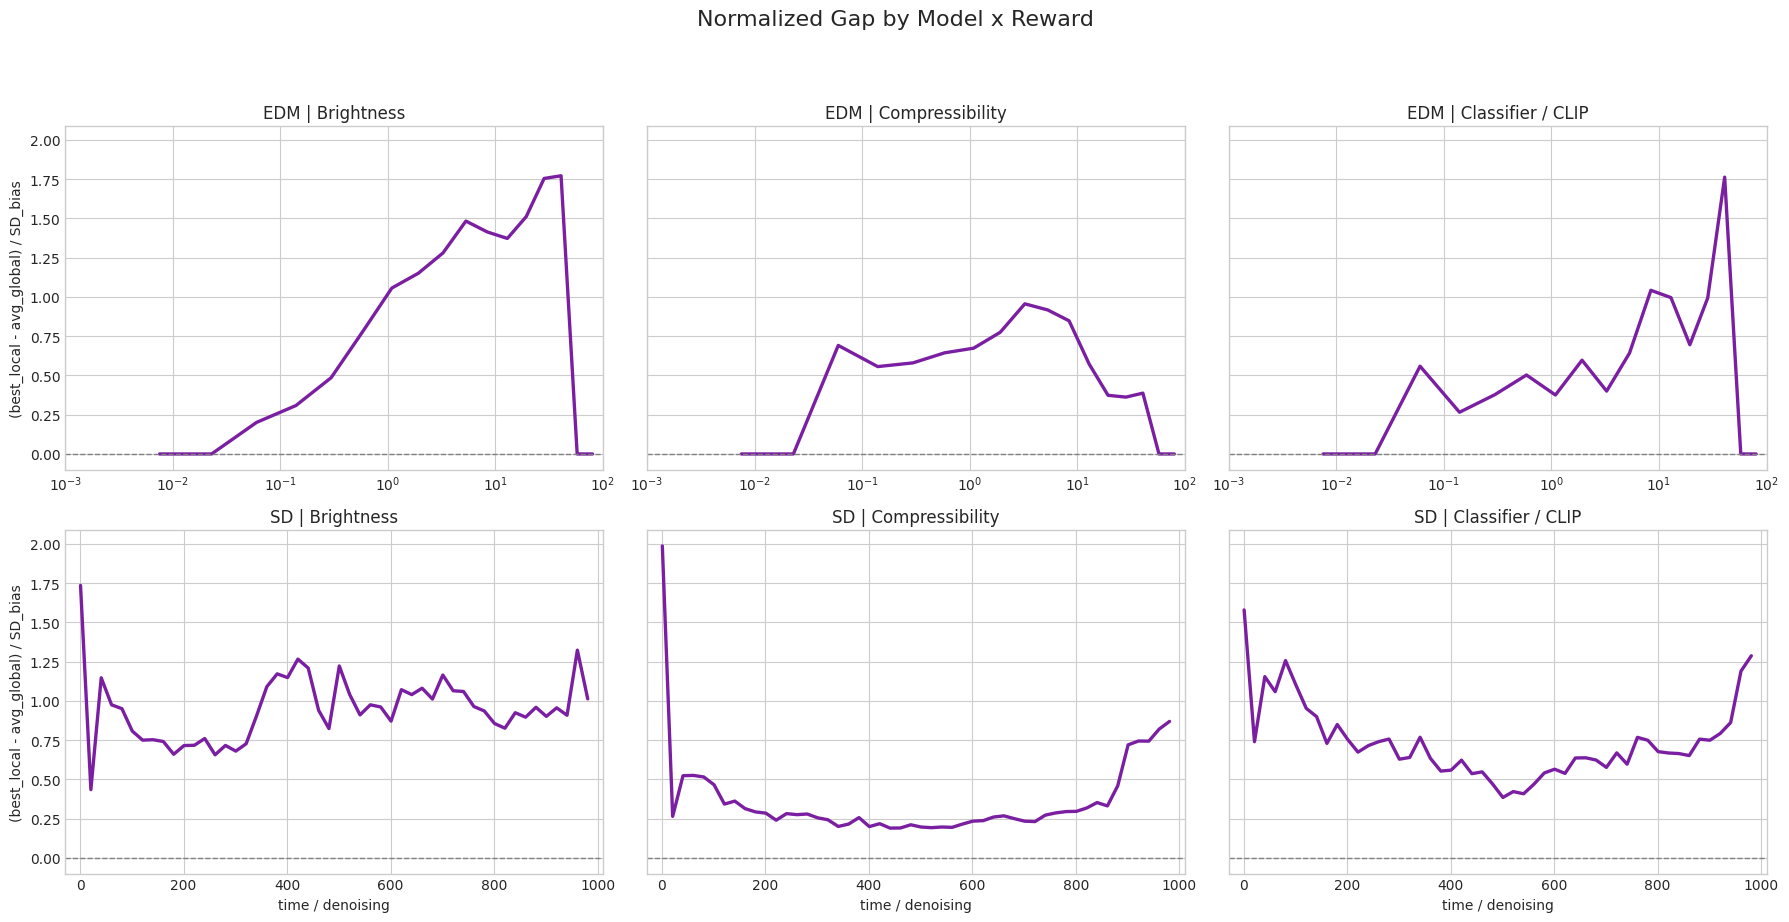

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=True)
for r, model in enumerate(MODELS):
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)
    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        zc = panel[(model, col_key)]['z_curve']

        if zc is None or zc.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        ax.plot(zc['x'], zc['z_local_minus_avg_global'], color='#7B1FA2', linewidth=2.4)
        ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.0)
        ax.set_title(f'{model} | {COL_LABELS[col_key]}')

        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
        if model_xlim is not None:
            ax.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('time / denoising')
for ax in axes[:, 0]:
    ax.set_ylabel('(best_local - avg_global) / SD_bias')

fig.suptitle('Normalized Gap by Model x Reward', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

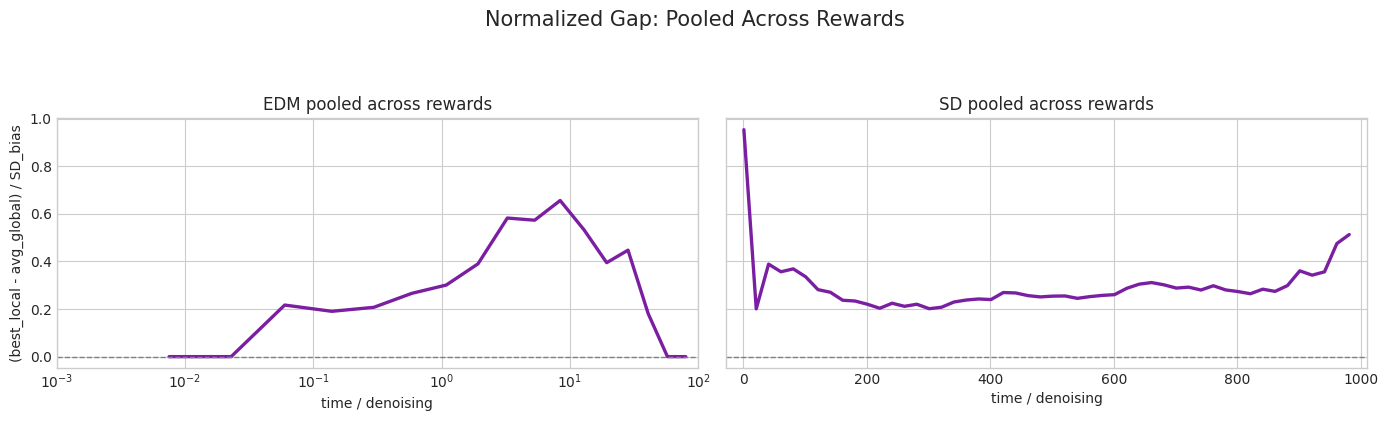

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
if len(MODELS) == 1:
    axes = [axes]

for i, model in enumerate(MODELS):
    ax = axes[i]
    zc = pooled_model[model]['z_curve']
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    model_xlim = xlim_by_model.get(model)

    if zc.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} pooled')
        continue

    ax.plot(zc['x'], zc['z_local_minus_avg_global'], color='#7B1FA2', linewidth=2.4)
    ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.0)
    ax.set_title(f'{model} pooled across rewards')
    ax.set_xlabel('time / denoising')

    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)

axes[0].set_ylabel('(best_local - avg_global) / SD_bias')
fig.suptitle('Normalized Gap: Pooled Across Rewards', y=1.04, fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()